权重衰退其实是一个最为常用的控制过拟合的方法，通过控制参数的值的范围大小

实际上就是用拉格朗日法来进行一个正则化，有约束的最优化问题

叫权重衰退是因为在实际的优化过程中，大概率weight的绝对值会越来越小

接下来我们来手动实现一下这个过程

In [10]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [12]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [13]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [14]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

正则化项为0

w的L2范数是： 14.918627738952637


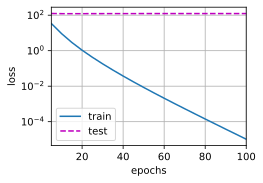

In [15]:
train(lambd=0)

正则化设置为3

w的L2范数是： 0.3701086640357971


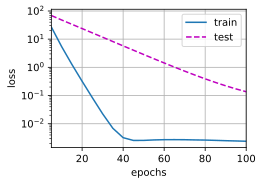

In [16]:
train(lambd=3)

下面是用torch的简洁实现

In [17]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.436370849609375


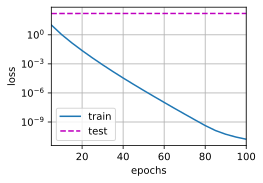

In [18]:
train_concise(0)

w的L2范数： 0.3729991912841797


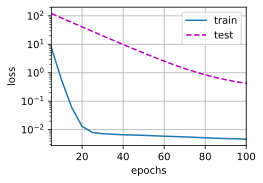

In [19]:
train_concise(3)

可以发现简洁实现和手动实现没啥差别，要注意的就是这个    
* trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
1. 这里其实就是学习框架比如torch已经把weight decay集成到优化器里面去了，我们用一个列表传入我们要的参数，同时在列表中制定好参数是啥以及训练要求就好
2. {"params":net[0].weight,'weight_decay': wd}，第一个字典，告诉要训练weight，然后还要进行wd
3. {"params":net[0].bias}这里就是说训练bias